In [52]:
%reload_ext autoreload
%autoreload 2


import sys
sys.path.append("..")

from common.utils import load_sql_to_df, plot_history, save_to_sql
from datasets import MoveAsTensorDataset
import board_representation as br

import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

from common.training import train_loop, test_model, Trainer
from models import *

import random

import chess
import chess.engine
from stockfish import Stockfish
import pandas as pd
from tqdm import tqdm

In [53]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [94]:
def filter_func(row):
    board = chess.Board(row['position'])
    return board.is_legal(chess.Move.from_uci(row['move']))



tables = ["classified_moves_big", "chessbase_moves_with_nags", "moves_from_books"] #, "random_moves"]
classified_moves = [load_sql_to_df(f"SELECT position, move, sentiment FROM {table_name}", "../../chess.db") for table_name in tables]
classified_moves = pd.concat(classified_moves)
classified_moves = classified_moves[classified_moves.apply(filter_func, axis=1)]
classified_moves

,position,move,sentiment
0,3brrk1/1q1n1ppp/pp6/2p5/Pn1pPPP1/3P1NN1/1P4QP/...,b7c6,1
1,3q1rk1/1p2ppbp/rnp1b1p1/p7/P2P4/2P3PP/2Q1PPB1/...,b6d7,1
2,5k2/3R3p/6p1/P2N1p2/5P2/4b3/3r3P/5K2 w - - 1 34,f1e1,1
3,rn2kb1r/p3pppp/2p1bn2/q7/PppP1P2/4PNN1/1P4PP/R...,f1e2,1
4,8/4k3/4p2p/2r3P1/6P1/1Pp5/P5R1/1K6 b - - 0 40,c5g5,1
...,...,...,...
863568,8/1kp2Q2/1pb5/p1P5/4r3/1PP5/3K4/8 b - - 0 56,b6b5,1
863569,8/1kp1PQ2/1pb5/p7/2P5/1P6/1KP1rp2/8 b - - 2 47,f2f1q,1
863570,8/1kp1PQ2/1pb5/p7/2P5/1P6/1KP1r3/5q2 w - - 0 48,f7f1,1
863571,8/1kp1P3/1pb5/p7/2P5/1P6/1KP1r3/5Q2 b - - 0 48,e2e7,1


In [97]:
save_to_sql(classified_moves, db_filename="../../chess.db", table_name="sentimate_training_set_no_random", if_exists='replace')

In [112]:
classified_moves = load_sql_to_df(f"SELECT position, move, sentiment FROM sentimate_training_set_no_random", "../../chess.db")
classified_moves

,position,move,sentiment
0,3brrk1/1q1n1ppp/pp6/2p5/Pn1pPPP1/3P1NN1/1P4QP/...,b7c6,1
1,3q1rk1/1p2ppbp/rnp1b1p1/p7/P2P4/2P3PP/2Q1PPB1/...,b6d7,1
2,5k2/3R3p/6p1/P2N1p2/5P2/4b3/3r3P/5K2 w - - 1 34,f1e1,1
3,rn2kb1r/p3pppp/2p1bn2/q7/PppP1P2/4PNN1/1P4PP/R...,f1e2,1
4,8/4k3/4p2p/2r3P1/6P1/1Pp5/P5R1/1K6 b - - 0 40,c5g5,1
...,...,...,...
2573086,8/1kp2Q2/1pb5/p1P5/4r3/1PP5/3K4/8 b - - 0 56,b6b5,1
2573087,8/1kp1PQ2/1pb5/p7/2P5/1P6/1KP1rp2/8 b - - 2 47,f2f1q,1
2573088,8/1kp1PQ2/1pb5/p7/2P5/1P6/1KP1r3/5q2 w - - 0 48,f7f1,1
2573089,8/1kp1P3/1pb5/p7/2P5/1P6/1KP1r3/5Q2 b - - 0 48,e2e7,1


In [108]:
bad_moves = classified_moves[classified_moves.sentiment == 0].copy()
bad_moves

,position,move,sentiment
6,r2qk2r/ppp2ppp/2n1bP2/2b3N1/2pp4/8/PPP2PPP/RNB...,d8f6,0
11,r4rk1/pbqn1ppp/1p2pn2/2p5/P1BP4/2P1PN2/1B3PPP/...,c4a2,0
15,2k2r2/1pp5/p2p4/3P1npp/2P5/1P1Q1PN1/P4KPP/r7 w...,g3f5,0
23,3r1r2/2q2ppk/p4b1p/nppppP2/8/2PP2RP/PPB2PP1/R1...,d1h5,0
32,rnbqkbnr/ppp1pp1p/3p2p1/8/3PP3/5N2/PPP2PPP/RNB...,f8g7,0
...,...,...,...
1734584,2rq1r2/5pkp/p1n1bn2/1pR5/3p4/P7/3Q1PPP/1BB1R1K...,f6g8,0
1734585,2rq1rk1/5ppp/p1n1bn2/1pR2N2/3p4/P7/1B1Q1PPP/1B...,f5d4,0
1734586,2rq1rk1/5ppp/p1n1bn2/1pR2N2/3p4/P7/1B1Q1PPP/1B...,d2g5,0
1734590,8/1RPb2pk/3B1r2/7p/4P3/6P1/5r1P/2R3K1 w - - 0 42,c7c8q,0


In [117]:
train_df, test_df = train_test_split(classified_moves, test_size=0.005, random_state=0)
display(train_df)
display(test_df)

,position,move,sentiment
285277,r3kb1r/1p1b1ppp/1qn1p3/p2pPn2/3P4/3B1N2/PPN2PP...,f5d4,0
1291308,r4rk1/p2n1ppp/bp1ppn2/2q3B1/2PR4/P1N1P3/1PQ2PP...,g5h4,0
1755293,1r3r2/p4pk1/4p3/2p1P3/2P4N/1Pn2RP1/8/7K w - - ...,f3c3,1
1784288,r4rk1/p1q3pp/2pbpn2/2p1p1B1/8/2NP1Q2/PPP3PP/R4...,a8b8,1
1693609,r1bq1rk1/1pp2p1n/1bnp3p/1N2p3/p3P1p1/1BPP2B1/P...,b3a4,0
...,...,...,...
2249467,1r6/1P6/3k4/3p2R1/3P2p1/4P3/4KP2/1r6 w - - 0 37,g5g4,1
963395,r1r1q1k1/p3n1pp/1pnBp3/3pPp2/3P1N1P/P2P2Q1/5PP...,e7g6,1
2215104,1r1qrbk1/3b1pp1/2n2P2/pp1pP2Q/3P4/2N5/PP3B1K/R...,f6g7,1
1484405,r1bq1rk1/1p3ppp/p1p2n2/2Ppb3/N7/1PBBP3/P4PPP/R...,e5h2,0


,position,move,sentiment
1678536,2r1r2k/p2n1pp1/1p2p2p/q3P2P/6R1/b1P2N2/P1RBQPP...,d2h6,1
1747106,8/5ppk/4p1b1/Q2pP3/6rP/6N1/Pq3B2/4R1K1 b - - 0 30,g6e4,1
963872,r3r1k1/1q1n1p1p/pn1p2p1/2pP4/3bP1P1/2N1BP2/RP1...,e3h6,0
623310,6r1/3r1pk1/1pb1p1p1/p1q1P2P/P4P2/2Pp2RQ/1P1N3P...,d7d4,0
388755,6k1/8/p6p/2p1Np2/5P2/4p1PK/r2r3P/1R6 w - - 6 61,g3g4,0
...,...,...,...
592597,rnbqk1nr/ppp1bppp/3p4/8/3NP3/8/PPP2PPP/RNBQKB1...,b1c3,0
510267,3r2k1/2q1rp2/pQ4p1/P1pPR1Pp/N1P2P1P/8/2b3B1/6K...,a4c5,1
1229916,2r1k2r/p3bp1p/4pp2/8/n1pP4/PpB2NP1/1P1KPP1P/R5...,e8d7,1
1115317,8/3B4/2P3k1/4bpqp/p3p3/7Q/P2N4/5K2 b - - 1 45,h5h4,1


In [118]:
train_dataset = MoveAsTensorDataset(train_df)
test_dataset = MoveAsTensorDataset(test_df)

In [60]:
model = SentimateNet()
model.to(device)
model

SentimateNet(
  (conv_layers): Sequential(
    (0): Conv2d(26, 26, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): Dropout(p=0.25, inplace=False)
    (2): Conv2d(26, 26, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_layers): Sequential(
    (0): Dropout(p=0.25, inplace=False)
    (1): Linear(in_features=1664, out_features=500, bias=True)
    (2): ELU(alpha=1.0)
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=500, out_features=200, bias=True)
    (5): ELU(alpha=1.0)
    (6): Dropout(p=0.25, inplace=False)
    (7): Linear(in_features=200, out_features=1, bias=True)
  )
)

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma = 0.95)

In [77]:
train_loader = DataLoader(train_dataset, batch_size=4096, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4096)

In [26]:
# test_model(train_loader, model)
test_model(test_loader, model)

Test Error: Accuracy: 37.22%, Avg loss: 0.696382


In [27]:
trainer = Trainer(model=model, train_dataLoader=train_loader, val_dataLoader=test_loader, optimizer=optimizer, scheduler=scheduler, x_dtype=torch.float32, y_dtype=torch.float32)

In [29]:
trainer.train(40, verbose=True)

Epoch 21/60
Train loss: 0.314908, accuracy: 87.85%
Val loss:   0.306023, accuracy: 88.17%
-----------------------------
Epoch 22/60
Train loss: 0.314423, accuracy: 87.86%
Val loss:   0.305976, accuracy: 88.17%
-----------------------------
Epoch 23/60
Train loss: 0.314242, accuracy: 87.86%
Val loss:   0.305853, accuracy: 88.20%
-----------------------------
Epoch 24/60
Train loss: 0.313876, accuracy: 87.87%
Val loss:   0.305165, accuracy: 88.19%
-----------------------------
Epoch 25/60
Train loss: 0.313305, accuracy: 87.89%
Val loss:   0.305857, accuracy: 88.21%
-----------------------------
Epoch 26/60
Train loss: 0.313079, accuracy: 87.88%
Val loss:   0.304575, accuracy: 88.19%
-----------------------------
Epoch 27/60
Train loss: 0.312853, accuracy: 87.89%
Val loss:   0.304519, accuracy: 88.21%
-----------------------------
Epoch 28/60
Train loss: 0.312484, accuracy: 87.90%
Val loss:   0.304763, accuracy: 88.20%
-----------------------------
Epoch 29/60
Train loss: 0.312228, accura

In [50]:
trainer.optimizer.param_groups

[{'params': [Parameter containing:
   tensor([[[[ 1.2471e-02, -8.5371e-02,  6.7437e-02,  3.6831e-02,  1.3363e-01],
             [ 4.7877e-02, -1.6190e-01, -1.6240e-01, -3.7855e-02, -7.8901e-02],
             [-4.2268e-02, -1.5293e-01, -5.7311e-01, -3.0214e-01, -2.1054e-01],
             [-5.2700e-02, -1.7339e-01, -1.8803e-01, -3.2302e-01, -4.9830e-02],
             [ 7.2131e-03, -2.2370e-01, -8.0318e-02, -1.6828e-01, -1.3763e-02]],
   
            [[-4.0999e-02, -7.4272e-02, -1.6852e-01, -2.2014e-01, -9.6256e-03],
             [-3.5934e-02,  1.4006e-01,  1.1865e-01, -1.3116e-02,  6.3283e-02],
             [ 2.4201e-01,  2.8315e-01,  2.4649e-01,  7.2465e-02,  8.1780e-02],
             [-8.5300e-02, -1.9670e-01,  2.6443e-01, -1.8879e-01, -6.9015e-02],
             [-2.7440e-01,  1.9883e-02, -1.0543e-01, -1.0839e-01, -1.0407e-01]],
   
            [[ 8.0439e-02,  7.7948e-02, -1.8806e-01, -1.1077e-01,  1.0009e-01],
             [-7.4965e-02,  6.2267e-02,  1.3144e-01,  8.9612e-03, -7.0246e-

In [51]:
trainer.scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda ep: 0.99)
trainer.train(20, verbose=True)

Epoch 104/123
Train loss: 0.306253, accuracy: 88.01%
Val loss:   0.300308, accuracy: 88.26%
-----------------------------
Epoch 105/123
Train loss: 0.306057, accuracy: 88.01%
Val loss:   0.300254, accuracy: 88.27%
-----------------------------
Epoch 106/123
Train loss: 0.306199, accuracy: 88.01%
Val loss:   0.300150, accuracy: 88.26%
-----------------------------
Epoch 107/123
Train loss: 0.306184, accuracy: 88.00%
Val loss:   0.300150, accuracy: 88.28%
-----------------------------
Epoch 108/123
Train loss: 0.306197, accuracy: 88.01%
Val loss:   0.300280, accuracy: 88.25%
-----------------------------
Epoch 109/123
Train loss: 0.306116, accuracy: 88.02%
Val loss:   0.300323, accuracy: 88.27%
-----------------------------
Epoch 110/123
Train loss: 0.306219, accuracy: 88.00%
Val loss:   0.300224, accuracy: 88.31%
-----------------------------
Epoch 111/123
Train loss: 0.306012, accuracy: 88.02%
Val loss:   0.300409, accuracy: 88.27%
-----------------------------
Epoch 112/123
Train loss

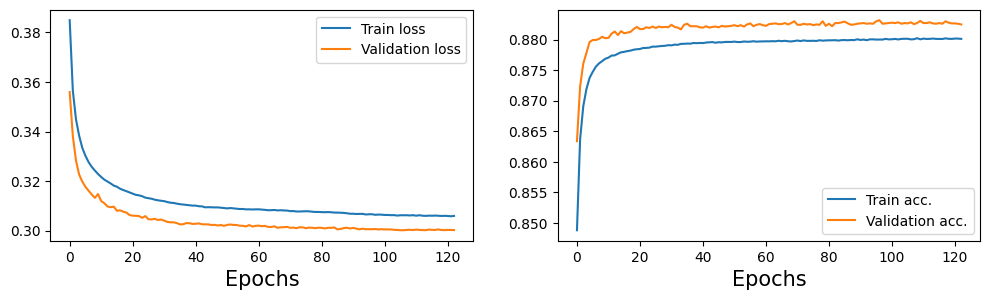

In [55]:
trainer.plot_history()

In [36]:
trainer.best_model()


Loading best params on validation set (epoch 97, accuracy: 88.32%)



SentimateNet(
  (conv_layers): Sequential(
    (0): Conv2d(26, 26, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): Dropout(p=0.25, inplace=False)
    (2): Conv2d(26, 26, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_layers): Sequential(
    (0): Dropout(p=0.25, inplace=False)
    (1): Linear(in_features=1664, out_features=500, bias=True)
    (2): ELU(alpha=1.0)
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=500, out_features=200, bias=True)
    (5): ELU(alpha=1.0)
    (6): Dropout(p=0.25, inplace=False)
    (7): Linear(in_features=200, out_features=1, bias=True)
  )
)

In [53]:
best_model = trainer.best_model()


Loading best params on validation set (epoch 97, accuracy: 88.32%)



In [43]:
best_model = trainer.best_model()


Loading best params on validation set (epoch 69, accuracy: 88.32%)



In [78]:
model = SentimateNet(dropout=0)
model.to(device)
model

SentimateNet(
  (conv_layers): Sequential(
    (0): Conv2d(26, 26, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): Dropout(p=0, inplace=False)
    (2): Conv2d(26, 26, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_layers): Sequential(
    (0): Dropout(p=0, inplace=False)
    (1): Linear(in_features=1664, out_features=500, bias=True)
    (2): ELU(alpha=1.0)
    (3): Dropout(p=0, inplace=False)
    (4): Linear(in_features=500, out_features=200, bias=True)
    (5): ELU(alpha=1.0)
    (6): Dropout(p=0, inplace=False)
    (7): Linear(in_features=200, out_features=1, bias=True)
  )
)

In [79]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma = 0.95)
trainer = Trainer(model=model, train_dataLoader=train_loader, val_dataLoader=test_loader, optimizer=optimizer, scheduler=scheduler, x_dtype=torch.float32, y_dtype=torch.float32)

In [80]:
trainer.train(20, verbose=True)

Epoch 1/20
Train loss: 0.378144, accuracy: 85.19%
Val loss:   0.353138, accuracy: 86.46%
-----------------------------
Epoch 2/20
Train loss: 0.347385, accuracy: 86.74%
Val loss:   0.335362, accuracy: 87.28%
-----------------------------
Epoch 3/20
Train loss: 0.333094, accuracy: 87.35%
Val loss:   0.322775, accuracy: 87.84%
-----------------------------
Epoch 4/20
Train loss: 0.323182, accuracy: 87.69%
Val loss:   0.316303, accuracy: 87.94%
-----------------------------
Epoch 5/20
Train loss: 0.315659, accuracy: 87.88%
Val loss:   0.312297, accuracy: 88.08%
-----------------------------
Epoch 6/20
Train loss: 0.309451, accuracy: 88.01%
Val loss:   0.308753, accuracy: 88.21%
-----------------------------
Epoch 7/20
Train loss: 0.304075, accuracy: 88.09%
Val loss:   0.308500, accuracy: 88.13%
-----------------------------
Epoch 8/20
Train loss: 0.298744, accuracy: 88.18%
Val loss:   0.307981, accuracy: 88.16%
-----------------------------
Epoch 9/20
Train loss: 0.293536, accuracy: 88.28

In [54]:
# torch.save(model.state_dict(), "../../models/Sentimate-6.01/last.model")
# torch.save(best_model.state_dict(), "../../models/Sentimate-6.05/best.model")
# model.load_state_dict(torch.load("../../models/Sentimate_bad.model"))

In [61]:
model.load_state_dict(torch.load("../../models/Sentimate-6.05/best.model"))

<All keys matched successfully>

In [43]:
best_model.to(device)
test_model(test_loader, best_model)

Test Error: Accuracy: 88.32%, Avg loss: 0.300553


In [81]:
class Agent:
    def __init__(self) -> None:
        pass

    def play(self, board: chess.Board):
        pass

class ModelAgent(Agent):
    def __init__(self, model) -> None:
        super().__init__()
        self.model = model
        self.model_device = next(iter(model.parameters())).device
        self.model_dtype = next(iter(model.parameters())).dtype

    def batch_legal_moves(self, board: chess.Board):
        move_tensors = [br.move_to_tensor(board.fen(), move) for move in board.legal_moves]
        return torch.stack(move_tensors)

    def play(self, board: chess.Board):
        legal_moves = list(board.legal_moves)

        if len(legal_moves) == 0:
            return None
        
        batch_moves = self.batch_legal_moves(board).to(self.model_device, dtype=self.model_dtype)

        self.model.eval()
        with torch.inference_mode():
            out = self.model(batch_moves)
            best_move_ind = out.argmax().item()
            best_move = list(board.legal_moves)[best_move_ind]

            return best_move

        
class RandomAgent(Agent):
    def __init__(self) -> None:
        super().__init__()

    def play(self, board: chess.Board):
        legal_moves = list(board.legal_moves)

        if len(legal_moves) == 0:
            return None

        random_move = random.choice(legal_moves)

        return random_move

In [82]:
from collections import Counter

engine = chess.engine.SimpleEngine.popen_uci("stockfish")

def batch_legal_moves(board: chess.Board):
    move_tensors = [br.move_to_tensor(board.fen(), move) for move in board.legal_moves]
    return torch.stack(move_tensors)

def model_best_move(board: chess.Board, model: nn.Module):
    agent = ModelAgent(model)
    return agent.play(board)
    

def compare_moves(board, move1, move2):
    result1 = engine.analyse(board, chess.engine.Limit(time=0.2), root_moves=[move1])
    result2 = engine.analyse(board, chess.engine.Limit(time=0.2), root_moves=[move2])
    
    if result1["score"].relative > result2["score"].relative:
        return -1
    elif result1["score"].relative < result2["score"].relative:
        return 1
    else:
        return 0
    
def compare_model_to_random_agent(model: nn.Module, fens, random_moves_from_position = 1):
    results = []
    for fen in fens:
        board = chess.Board(fen)

        legal_moves = list(board.legal_moves)

        model_move = model_best_move(board, model)

        for _ in range(random_moves_from_position):
            random_move = random.choice(legal_moves)
            comparison = compare_moves(board, model_move, random_move)
            results.append(comparison)

    stats = Counter(results)

    return {"model_better": stats[-1], "random_better": stats[1], "draw": stats[0]}

In [83]:
random_agent = RandomAgent()
model_agent = ModelAgent(model)

In [84]:
def play_game(white: Agent, black: Agent, n_moves = 40, verbose = False):
    board = chess.Board()

    if verbose:
        display(board)

    for i in range(n_moves):
        for agent in [white, black]:
            move = agent.play(board)

            if move == None:
                break

            board.push(move)

            if verbose:
                display(board)

    return board

def simple_result(board, time = 1):
    score = engine.analyse(board, chess.engine.Limit(time=time))['score'].white()

    if score <= chess.engine.Cp(-100):
        return -1
    elif score < chess.engine.Cp(100):
        return 0
    return 1

In [85]:
def test_agent(model_agent, n_games = 50, n_moves = 40, time = 1):
    random_agent = RandomAgent()
    results = []    

    for game in tqdm(range(n_games//2)):
        final_board = play_game(model_agent, random_agent, n_moves=40)
        score = simple_result(final_board, time=time)
        results.append(score)

    for game in tqdm(range(n_games//2)):
        final_board = play_game(random_agent, model_agent, n_moves=40)
        score = -simple_result(final_board, time=time)
        results.append(score)

    stats = Counter(results)

    return {"model_better": stats[1], "random_better": stats[-1], "draw": stats[0]}


In [39]:
model.to(device)
random_agent = RandomAgent()
model_agent = ModelAgent(model)
test_agent(model_agent, n_games=1000)

100%|██████████| 500/500 [14:28<00:00,  1.74s/it]


{'model_better': 856, 'random_better': 122, 'draw': 22}

In [91]:
best_model.cuda()
best_model_agent = ModelAgent(best_model)
test_agent(best_model_agent, n_games=1000)

100%|██████████| 500/500 [14:38<00:00,  1.76s/it]


{'model_better': 882, 'random_better': 101, 'draw': 17}

In [49]:
best_model.cuda()
best_model_agent = ModelAgent(best_model)
test_agent(best_model_agent, n_games=1000)

100%|██████████| 500/500 [14:27<00:00,  1.73s/it]


{'model_better': 887, 'random_better': 92, 'draw': 21}

In [25]:
model = torch.load("../../models/Sentimate_bad.model")
random_agent = RandomAgent()
model_agent = ModelAgent(model)
test_agent(model_agent, n_games=100)

{'model_better': 68, 'random_better': 30, 'draw': 2}

In [26]:
model = torch.load("../../models/Sentimate_good.model")
random_agent = RandomAgent()
model_agent = ModelAgent(model)

In [28]:
test_agent(model_agent, n_games=100)

{'model_better': 62, 'random_better': 34, 'draw': 4}

In [63]:
model = SentimateNetSmaller()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma = 0.99)
model

SentimateNetSmaller(
  (conv_layers): Sequential(
    (0): Conv2d(26, 13, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): Dropout(p=0.25, inplace=False)
    (2): Conv2d(13, 26, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_layers): Sequential(
    (0): Dropout(p=0.25, inplace=False)
    (1): Linear(in_features=1664, out_features=200, bias=True)
    (2): ELU(alpha=1.0)
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ELU(alpha=1.0)
    (6): Dropout(p=0.25, inplace=False)
    (7): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [64]:
trainer_2 = Trainer(model=model, train_dataLoader=train_loader, val_dataLoader=test_loader, optimizer=optimizer, scheduler=scheduler, x_dtype=torch.float32, y_dtype=torch.float32)

In [65]:
trainer_2.train(50, verbose=True)

Epoch 1/50
Train loss: 0.387549, accuracy: 84.75%
Val loss:   0.359533, accuracy: 86.16%
-----------------------------
Epoch 2/50
Train loss: 0.361657, accuracy: 86.13%
Val loss:   0.342334, accuracy: 87.04%
-----------------------------
Epoch 3/50
Train loss: 0.351033, accuracy: 86.66%
Val loss:   0.333993, accuracy: 87.41%
-----------------------------
Epoch 4/50
Train loss: 0.345741, accuracy: 86.90%
Val loss:   0.331138, accuracy: 87.56%
-----------------------------
Epoch 5/50
Train loss: 0.342788, accuracy: 87.03%
Val loss:   0.326798, accuracy: 87.75%
-----------------------------
Epoch 6/50
Train loss: 0.339953, accuracy: 87.15%
Val loss:   0.326296, accuracy: 87.73%
-----------------------------
Epoch 7/50
Train loss: 0.338341, accuracy: 87.21%
Val loss:   0.323304, accuracy: 87.86%
-----------------------------
Epoch 8/50
Train loss: 0.337047, accuracy: 87.26%
Val loss:   0.323195, accuracy: 87.85%
-----------------------------
Epoch 9/50
Train loss: 0.336219, accuracy: 87.28

In [66]:
model_agent = ModelAgent(model)
test_agent(model_agent, n_games=1000)

100%|██████████| 500/500 [14:16<00:00,  1.71s/it]


{'model_better': 869, 'random_better': 112, 'draw': 19}

In [35]:
# model = torch.load("../../models/Sentimate_smaller.model")
# random_agent = RandomAgent()
model_agent = ModelAgent(model)
test_agent(model_agent, n_games=1000)

{'model_better': 845, 'random_better': 123, 'draw': 32}

In [77]:
model = SentimateNetSkipLayer()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma = 0.99)
model

SentimateNetSkipLayer(
  (conv1): Sequential(
    (0): Conv2d(26, 26, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): Dropout(p=0.25, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(26, 26, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): Dropout(p=0.25, inplace=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1664, out_features=500, bias=True)
    (2): ELU(alpha=1.0)
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=500, out_features=200, bias=True)
    (5): ELU(alpha=1.0)
    (6): Dropout(p=0.25, inplace=False)
    (7): Linear(in_features=200, out_features=1, bias=True)
  )
)

In [80]:
trainer_3 = Trainer(model=model, train_dataLoader=train_loader, val_dataLoader=test_loader, optimizer=optimizer, scheduler=scheduler, x_dtype=torch.float32, y_dtype=torch.float32)

In [81]:
trainer_3.train(50, verbose=True)

Epoch 1/50
Train loss: 0.381766, accuracy: 85.06%
Val loss:   0.358309, accuracy: 86.05%
-----------------------------
Epoch 2/50
Train loss: 0.361648, accuracy: 86.06%
Val loss:   0.348813, accuracy: 86.62%
-----------------------------
Epoch 3/50
Train loss: 0.354222, accuracy: 86.40%
Val loss:   0.342424, accuracy: 87.00%
-----------------------------
Epoch 4/50
Train loss: 0.347701, accuracy: 86.71%
Val loss:   0.336761, accuracy: 87.29%
-----------------------------
Epoch 5/50
Train loss: 0.343007, accuracy: 86.93%
Val loss:   0.333503, accuracy: 87.34%
-----------------------------
Epoch 6/50
Train loss: 0.339115, accuracy: 87.09%
Val loss:   0.331148, accuracy: 87.49%
-----------------------------
Epoch 7/50
Train loss: 0.336321, accuracy: 87.20%
Val loss:   0.328128, accuracy: 87.51%
-----------------------------
Epoch 8/50
Train loss: 0.333621, accuracy: 87.30%
Val loss:   0.324091, accuracy: 87.72%
-----------------------------
Epoch 9/50
Train loss: 0.331480, accuracy: 87.38

In [82]:
trainer_3.optimizer = torch.optim.Adam(model.parameters(), lr=0.0015)

trainer_3.train(10, verbose=True)

Epoch 51/60
Train loss: 0.306559, accuracy: 87.98%
Val loss:   0.308543, accuracy: 88.18%
-----------------------------
Epoch 52/60
Train loss: 0.306374, accuracy: 87.98%
Val loss:   0.307230, accuracy: 88.17%
-----------------------------
Epoch 53/60
Train loss: 0.305664, accuracy: 88.00%
Val loss:   0.307205, accuracy: 88.14%
-----------------------------
Epoch 54/60
Train loss: 0.305593, accuracy: 88.00%
Val loss:   0.309431, accuracy: 88.09%
-----------------------------
Epoch 55/60
Train loss: 0.305009, accuracy: 88.01%


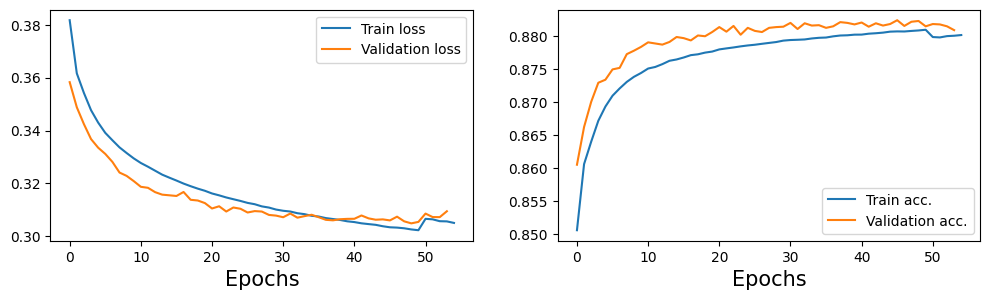

In [83]:
trainer_3.plot_history()

In [84]:
best_model_3 = trainer_3.best_model()
best_model_3_agent = ModelAgent(best_model_3)


Loading best params on validation set (epoch 46, accuracy: 88.24%)



In [86]:
test_agent(best_model_3_agent, n_games=100)

100%|██████████| 50/50 [01:37<00:00,  1.94s/it]


{'model_better': 78, 'random_better': 20, 'draw': 2}

In [89]:
model_agent = ModelAgent(trainer.best_model())


Loading best params on validation set (epoch 6, accuracy: 88.21%)



In [90]:
test_agent(model_agent, n_games=100)

100%|██████████| 50/50 [01:02<00:00,  1.24s/it]


{'model_better': 91, 'random_better': 7, 'draw': 2}

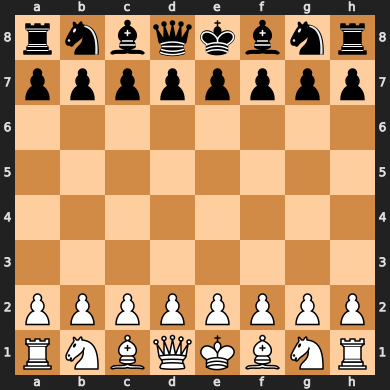

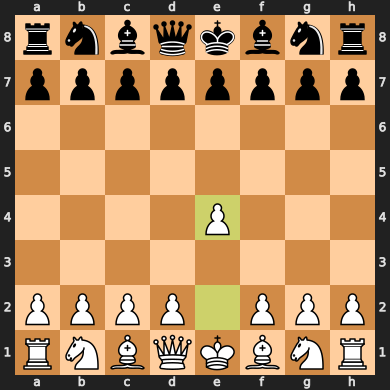

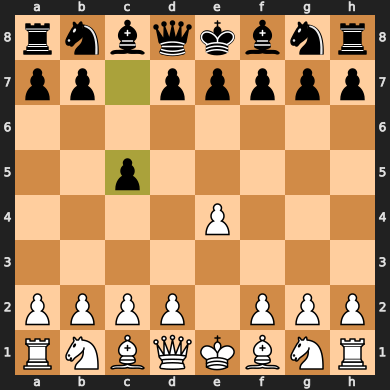

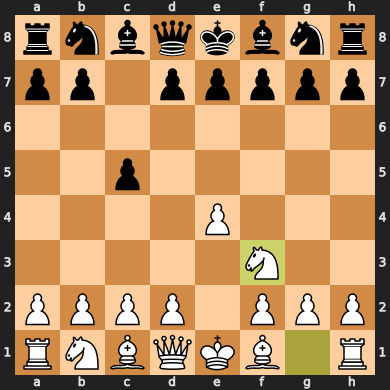

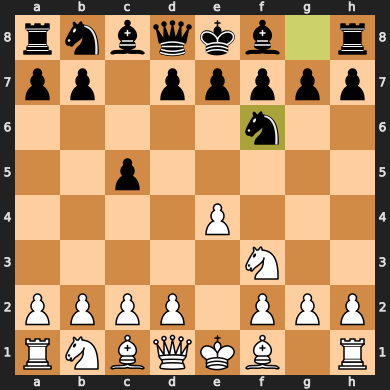

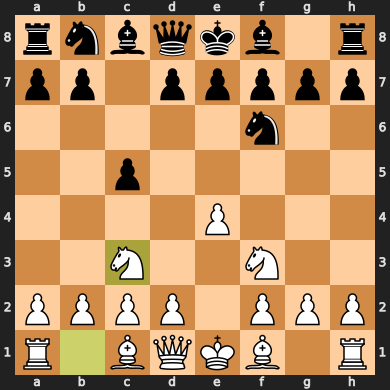

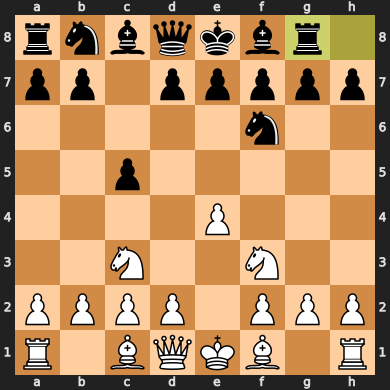

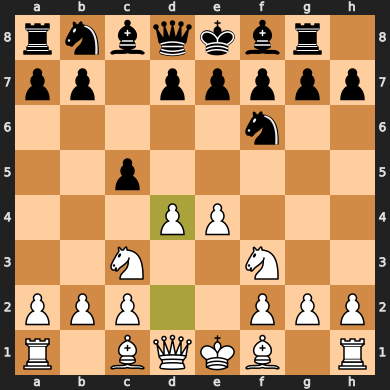

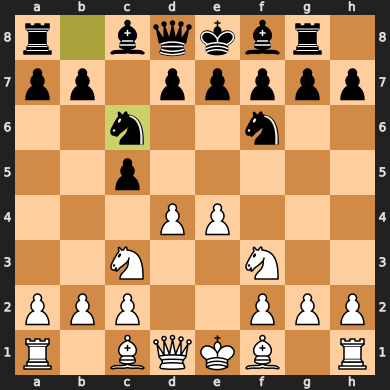

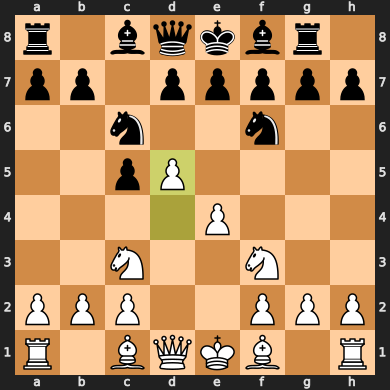

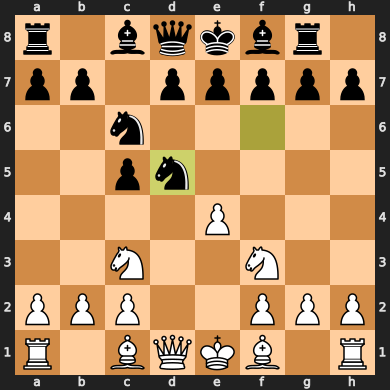

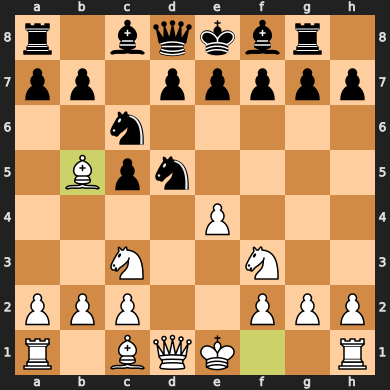

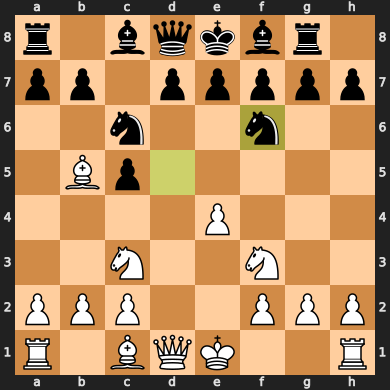

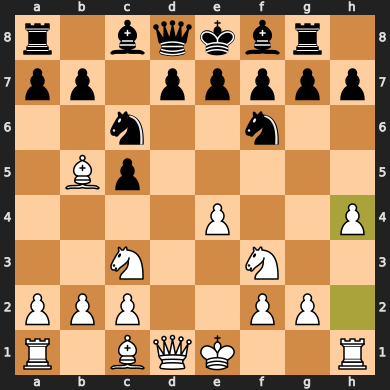

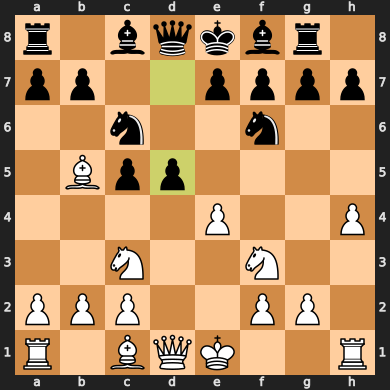

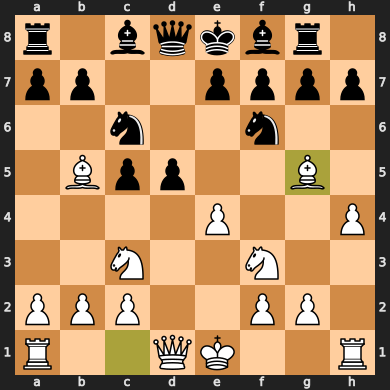

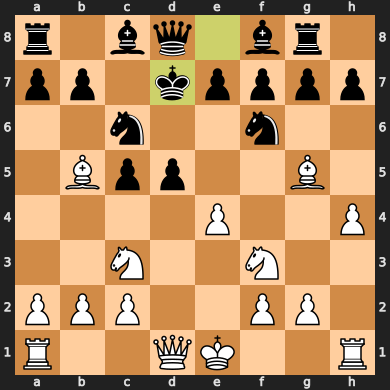

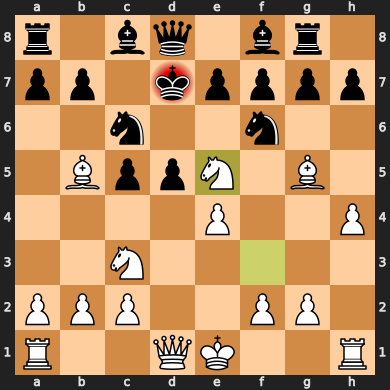

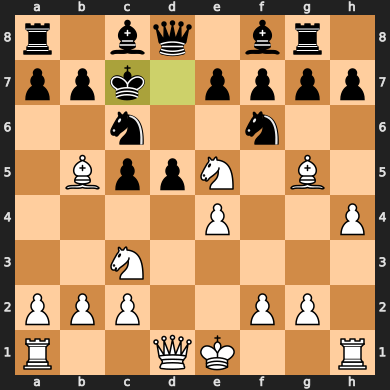

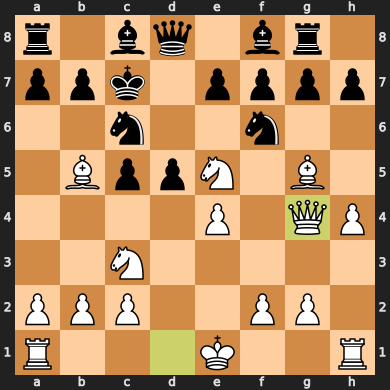

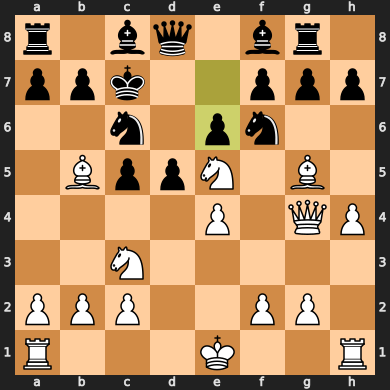

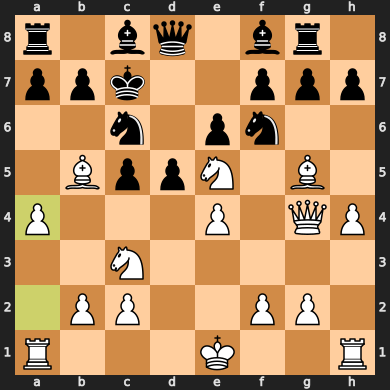

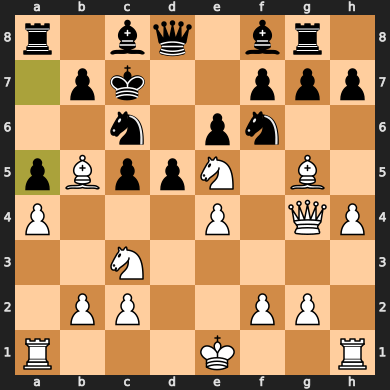

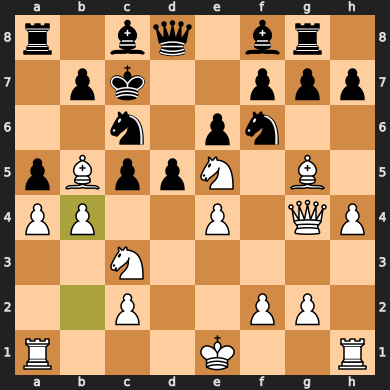

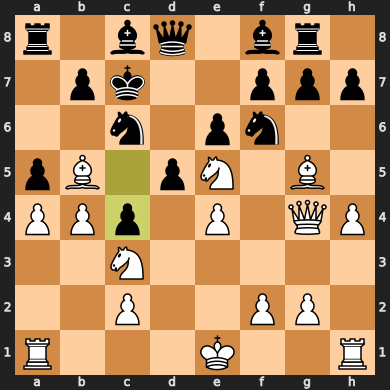

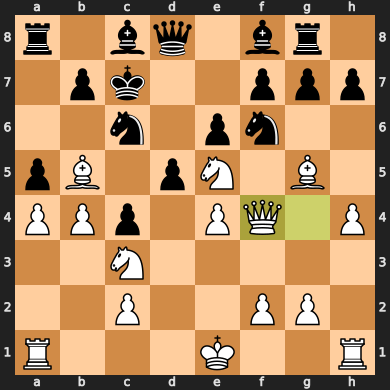

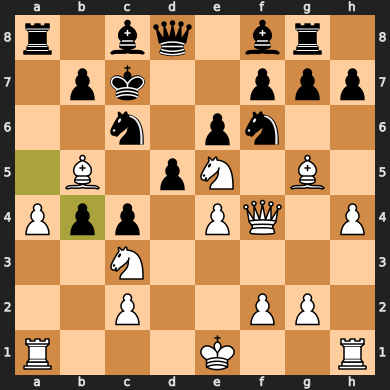

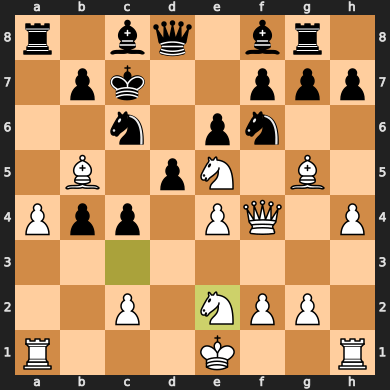

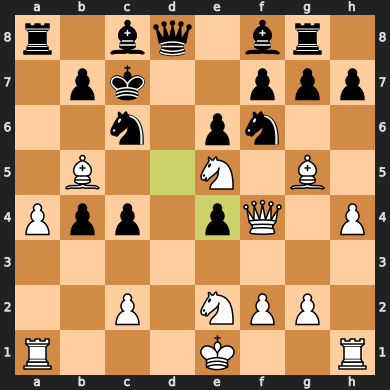

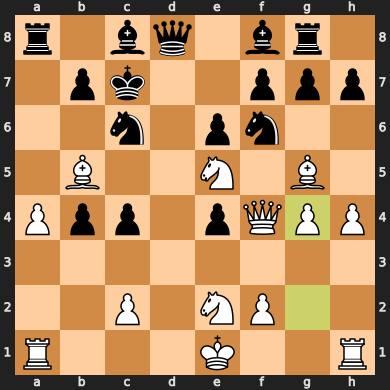

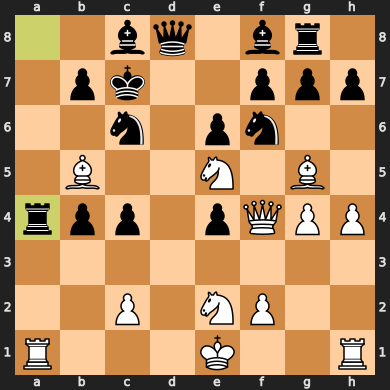

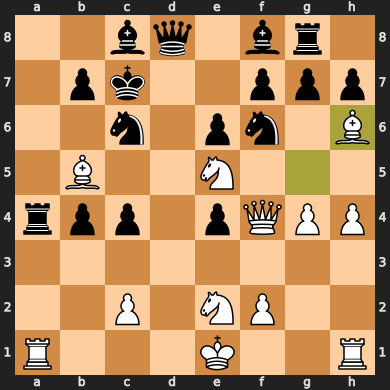

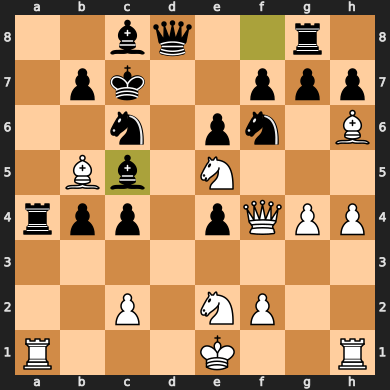

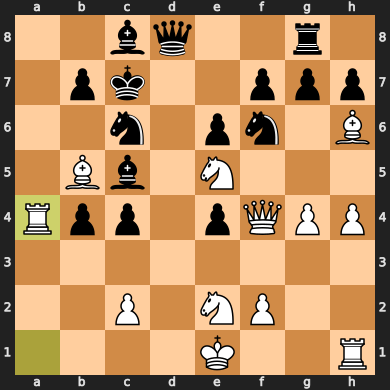

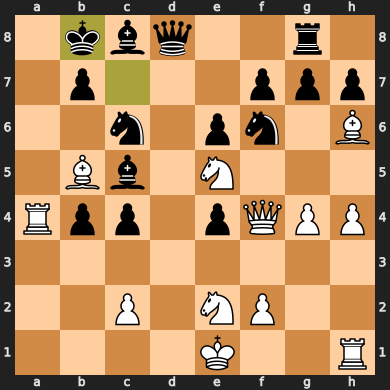

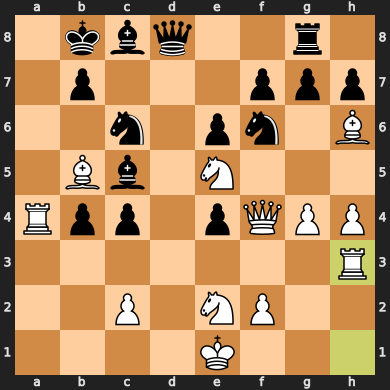

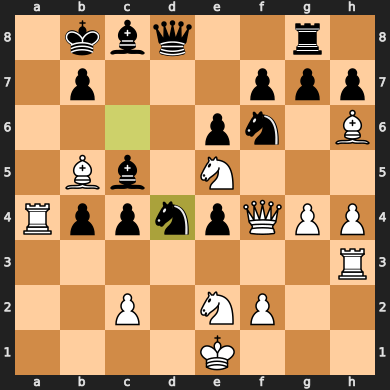

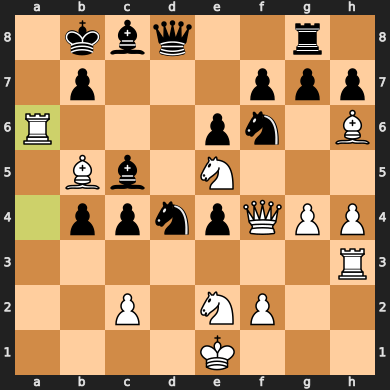

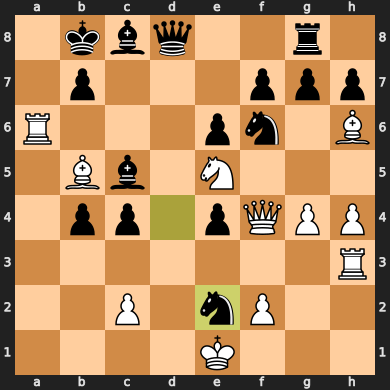

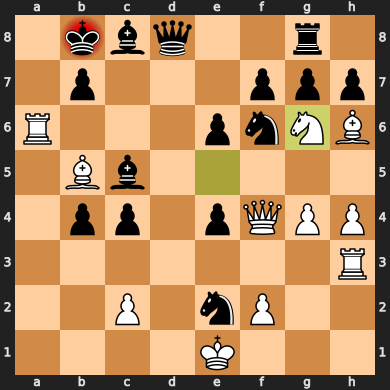

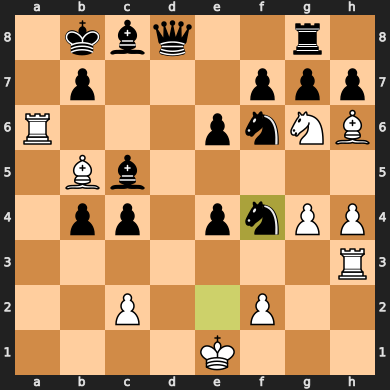

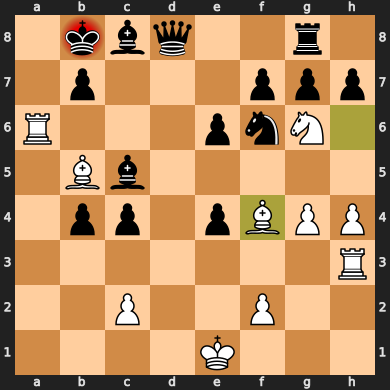

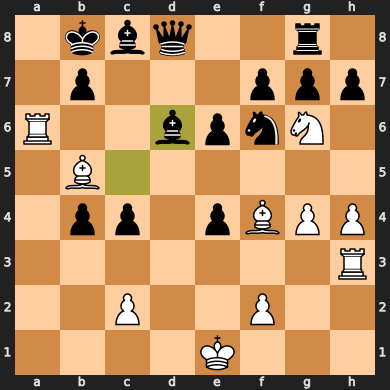

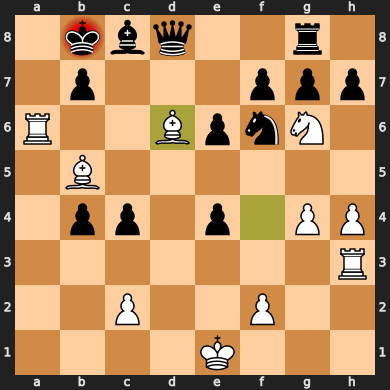

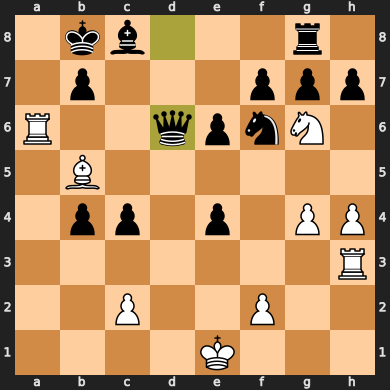

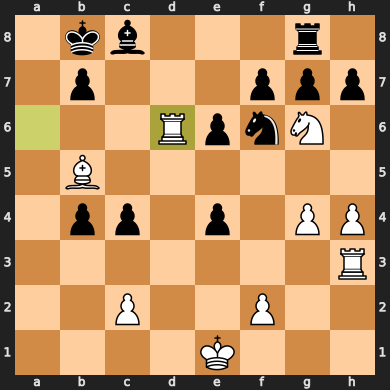

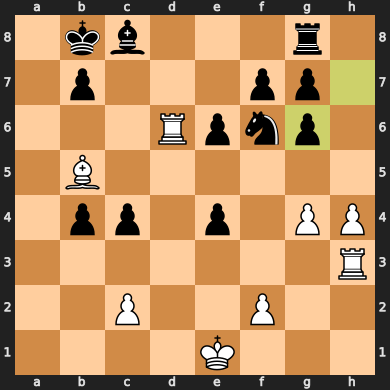

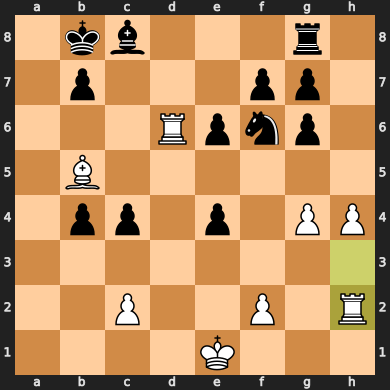

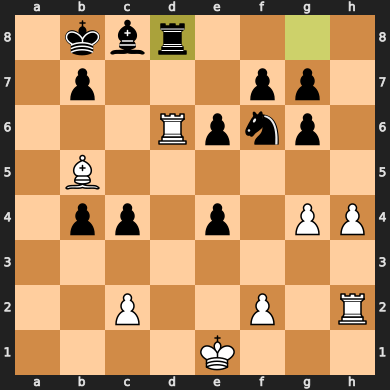

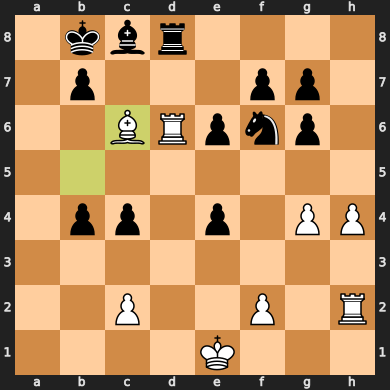

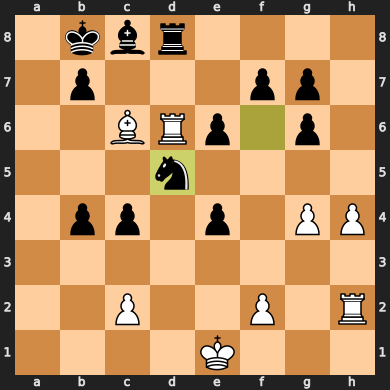

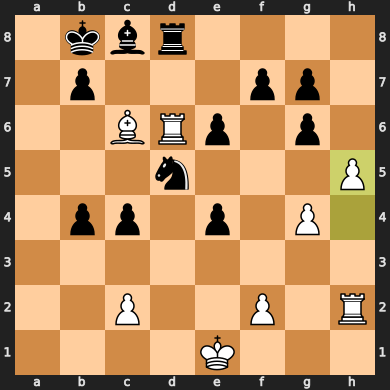

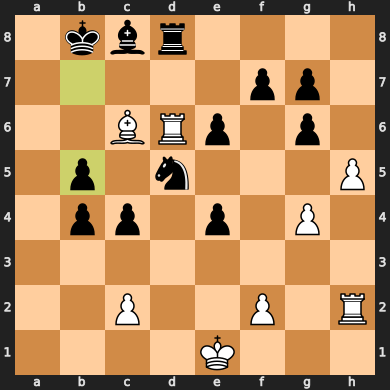

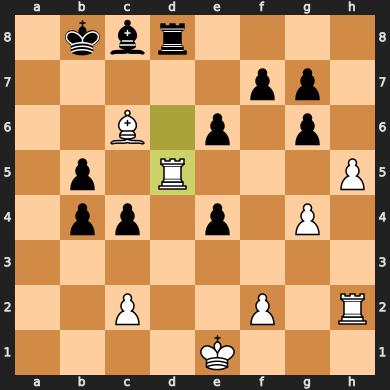

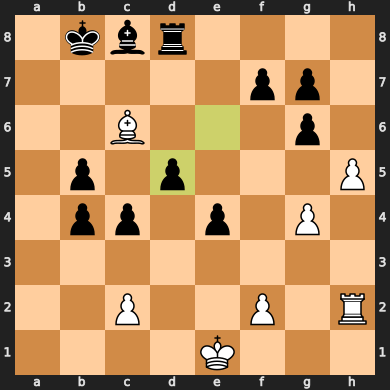

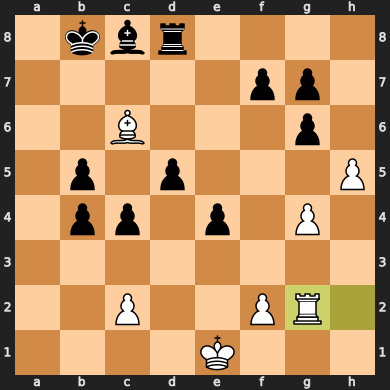

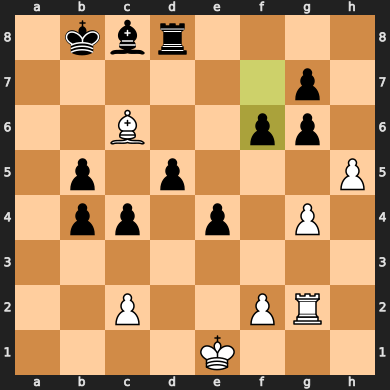

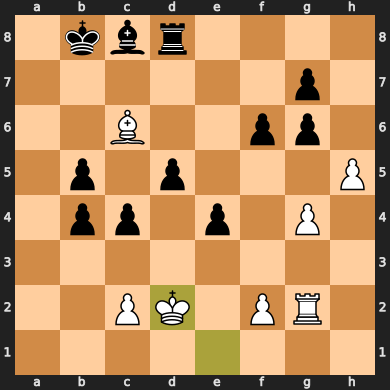

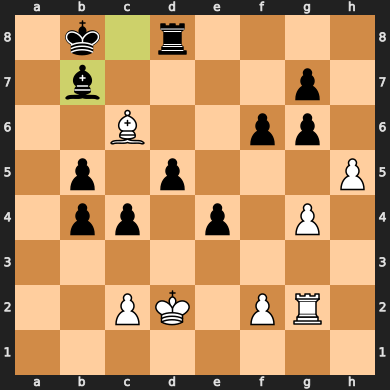

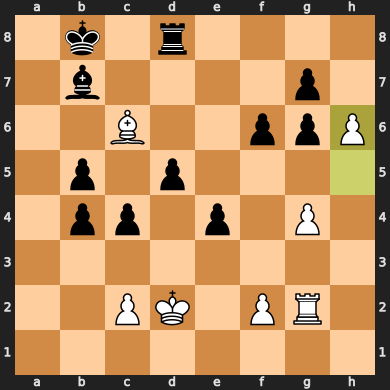

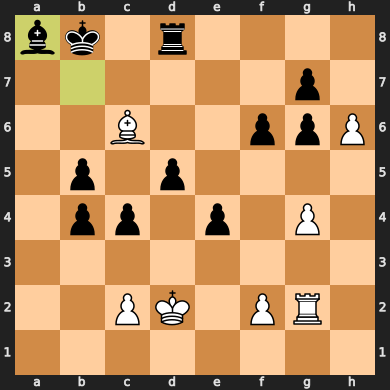

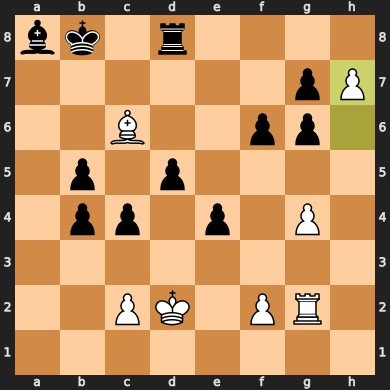

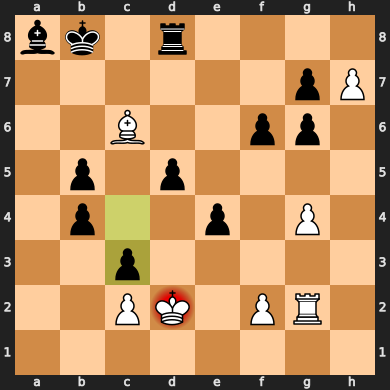

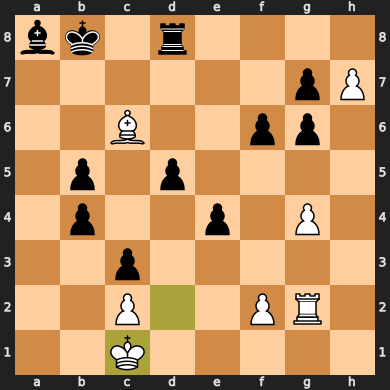

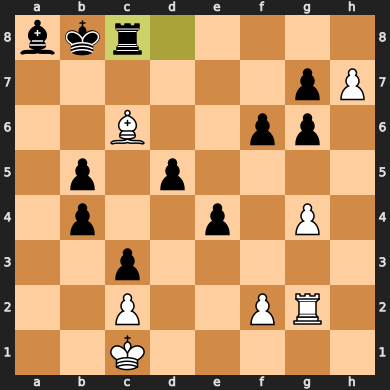

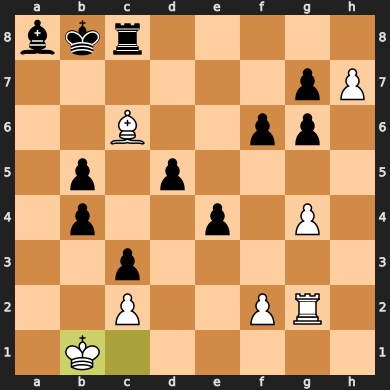

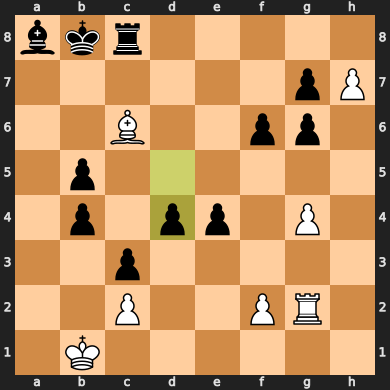

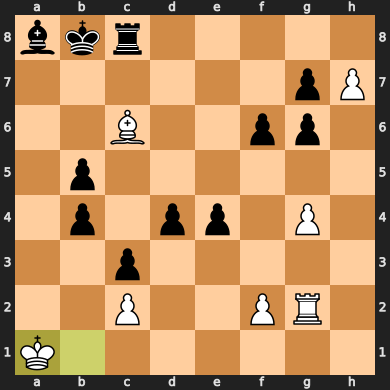

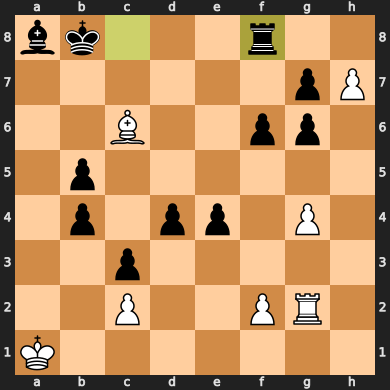

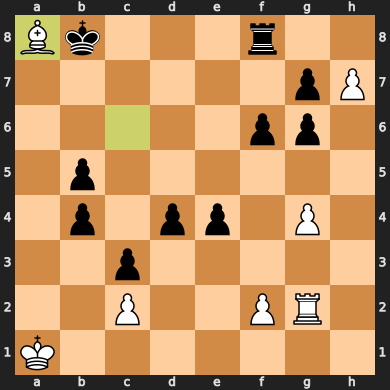

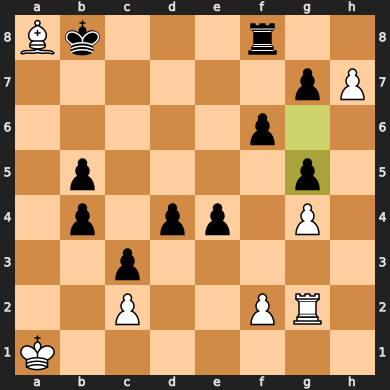

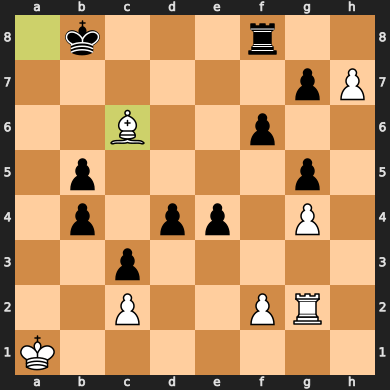

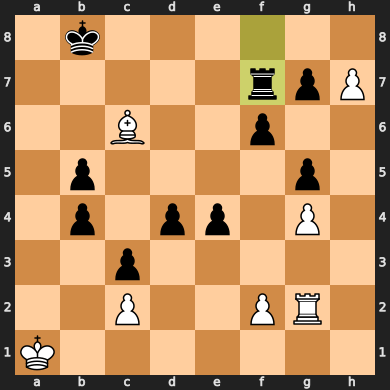

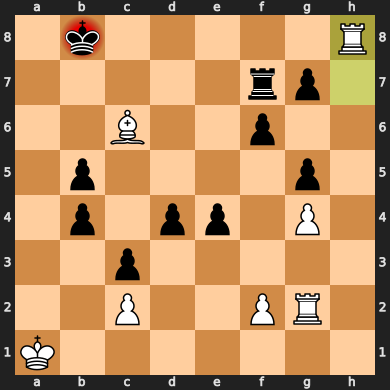

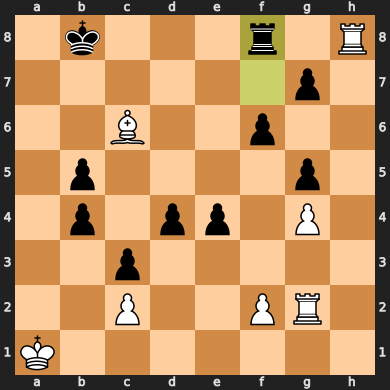

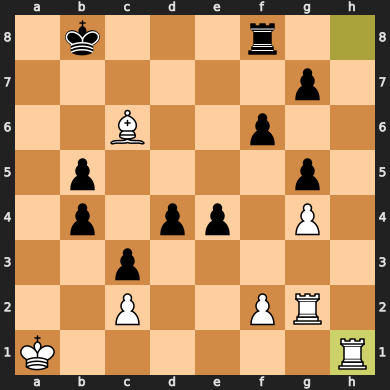

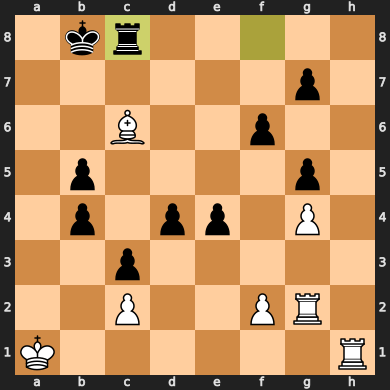

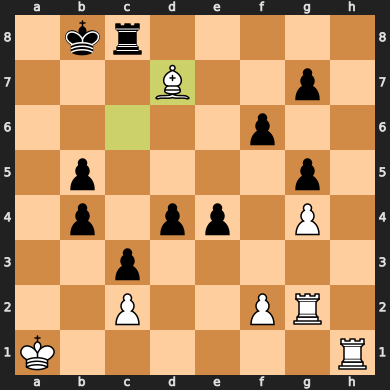

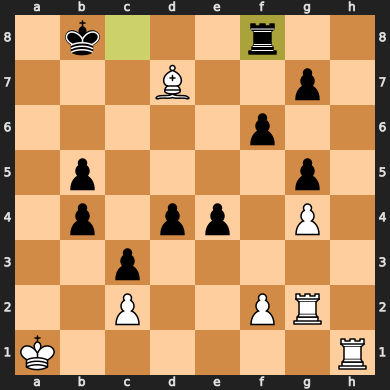

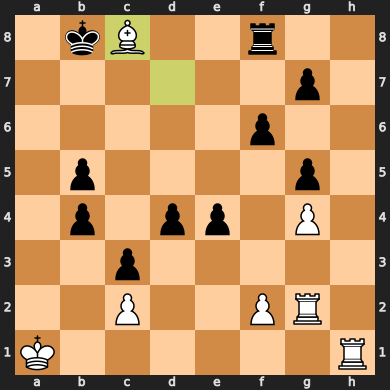

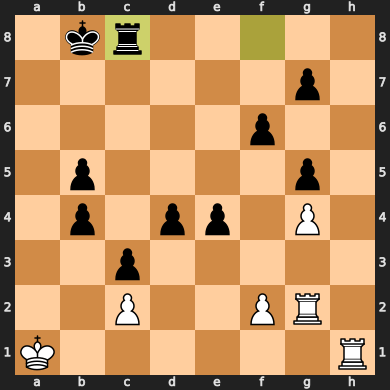

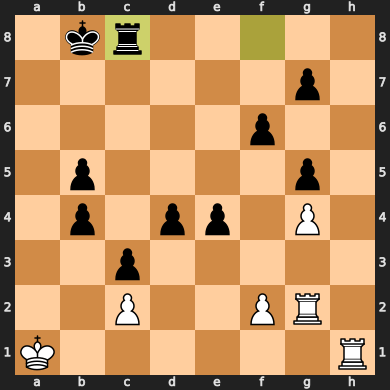

In [88]:
play_game(best_model_3_agent, best_model_agent, verbose=True)